In [243]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [244]:
FIGURES_DIR = "../figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

def save_plot(filename):
    path = os.path.join(FIGURES_DIR, filename)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved → {path}")


In [245]:
# ===============================
# 2. Create timeline (days to departure)
# ===============================
days = pd.DataFrame({
    "days_to_departure": np.arange(90, 0, -1)
})

sailing_date = pd.to_datetime("2026-01-19")
days["date"] = sailing_date - pd.to_timedelta(days["days_to_departure"], unit="D")


In [246]:
# ===============================
# 3. Define cabin products
# ===============================
cabins = pd.DataFrame({
    "cabin_type": ["Interior", "Outside", "Balcony"],
    "total_inventory": [300, 200, 100],
    "base_price": [250, 350, 500]
})


In [247]:
# ===============================
# 4. Cross join: time × product
# ===============================
df = days.merge(cabins, how="cross")


In [248]:
# ===============================
# 5. Demand index (urgency effect)
# ===============================
np.random.seed(123)

df["demand_index"] = (
    np.exp(-df["days_to_departure"] / 30)
    * np.random.normal(1.0, 0.1, len(df))
).clip(lower=0)


In [249]:
# ===============================
# 6. Price elasticity by cabin
# ===============================
elasticity_map = {
    "Interior": 1.4,
    "Outside": 1.2,
    "Balcony": 0.9
}

df["elasticity"] = df["cabin_type"].map(elasticity_map)


In [250]:
# ===============================
# 7. Daily price noise
# ===============================
df["daily_shock"] = np.random.normal(0, 0.04, len(df))


In [251]:
# ===============================
# 8. Inventory pressure (late booking window)
# ===============================
df["inventory_pressure"] = np.where(
    df["days_to_departure"] < 21,
    0.08,
    0.0
)


In [252]:
# ===============================
# 9. Raw price calculation
# ===============================
raw_price = (
    df["base_price"]
    * (1 + df["demand_index"] * df["elasticity"])
    * (1 + df["daily_shock"])
    * (1 + df["inventory_pressure"])
)
# Price increases because of: demand pressure,random daily noise, late-window inventory pressure

In [253]:
# ===============================
# 10. Price bounds
# ===============================
price_bounds = {
    "Interior": (250, 600),
    "Outside": (320, 750),
    "Balcony": (450, 1000)
}

df[["price_floor", "price_cap"]] = df["cabin_type"].apply(
    lambda x: pd.Series(price_bounds[x])
)

In [254]:
# ===============================
# 11. Final price + smoothing
# ===============================
df["price"] = (
    raw_price
    .clip(lower=df["price_floor"], upper=df["price_cap"])
    .round(0)
)

df = df.sort_values(["cabin_type", "days_to_departure"])

df["price"] = (
    df.groupby("cabin_type")["price"]
      .rolling(window=3, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
      .round(0)
)

In [255]:
# ===============================
# 12. Booking simulation
# ===============================
base_demand = {
    "Interior": 5,
    "Outside": 3,
    "Balcony": 1.5
}

# daily demand volatility
df["demand_shock"] = np.random.lognormal(mean=0, sigma=0.35, size=len(df))


def simulate_one_cabin(g):
    g = g.sort_values("days_to_departure", ascending=False).copy()

    remaining = int(g["total_inventory"].iloc[0])
    bookings = []
    remaining_inventory = []

    for _, row in g.iterrows():
        demand = base_demand[row["cabin_type"]]
        price_ratio = (row["price"] / row["base_price"]) - 1
        price_effect = np.exp(-row["elasticity"] * price_ratio)

        expected_bookings = max(
            demand * price_effect * row["demand_shock"],
            0
        )

        booked = int(np.random.poisson(expected_bookings))
        booked = min(booked, remaining)

        bookings.append(booked)
        remaining_inventory.append(remaining)

        remaining -= booked

    g["bookings"] = bookings
    g["remaining_inventory"] = remaining_inventory
    g["daily_revenue"] = g["bookings"] * g["price"]
    g["cumulative_revenue"] = g["daily_revenue"].cumsum()

    return g


df = df.groupby("cabin_type", group_keys=False).apply(simulate_one_cabin)

/var/folders/z2/nqrvw2956m7fq60mbs3bnl5c0000gn/T/ipykernel_86181/1167890987.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("cabin_type", group_keys=False).apply(simulate_one_cabin)


In [256]:
# ===============================
# 13. Final sorting (day-first view)
# ===============================
df = df.sort_values("days_to_departure", ascending=False).reset_index(drop=True)

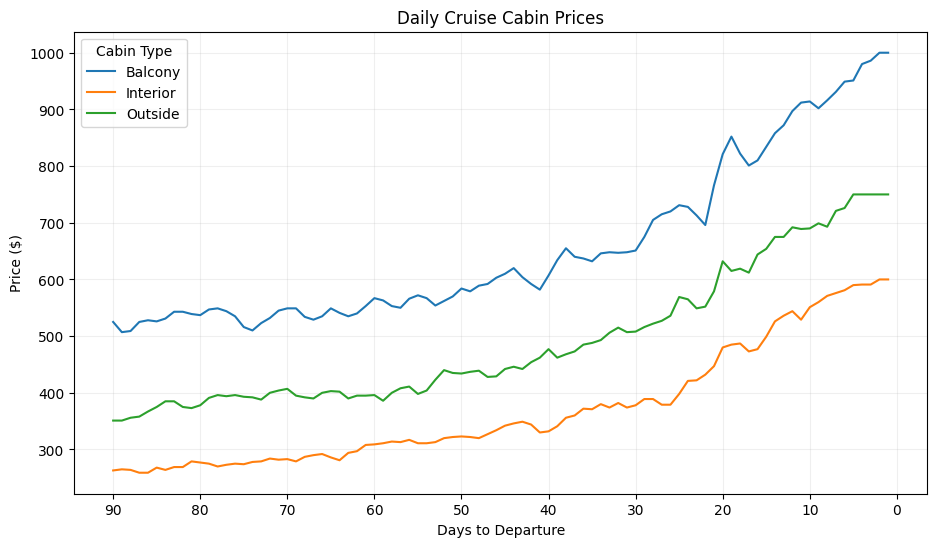

In [257]:
# ===============================
# 14. Plots
# ===============================
price_matrix = (
    df.groupby(["days_to_departure", "cabin_type"], as_index=False)
      .agg(price=("price", "mean"))
      .pivot(
          index="days_to_departure",
          columns="cabin_type",
          values="price"
      )
      .sort_index()
)
plt.figure(figsize=(11, 6))
for cabin in price_matrix.columns:
    plt.plot(price_matrix.index, price_matrix[cabin], label=cabin)
ticks = list(range(
    int(price_matrix.index.max()),
    -1,
    -10
))
plt.xticks(ticks)
plt.gca().invert_xaxis()
plt.xlabel("Days to Departure")
plt.ylabel("Price ($)")
plt.title("Daily Cruise Cabin Prices")
plt.legend(title="Cabin Type")
plt.grid(alpha=0.2)
plt.savefig(
    "../figures/02_Daily_Cruise_Cabin_Prices.png",
    dpi=300,
    bbox_inches="tight")
plt.show()

In [258]:
df["pct_sold"] = (
    (1 - df["remaining_inventory"] / df["total_inventory"]
) * 100).round(1)

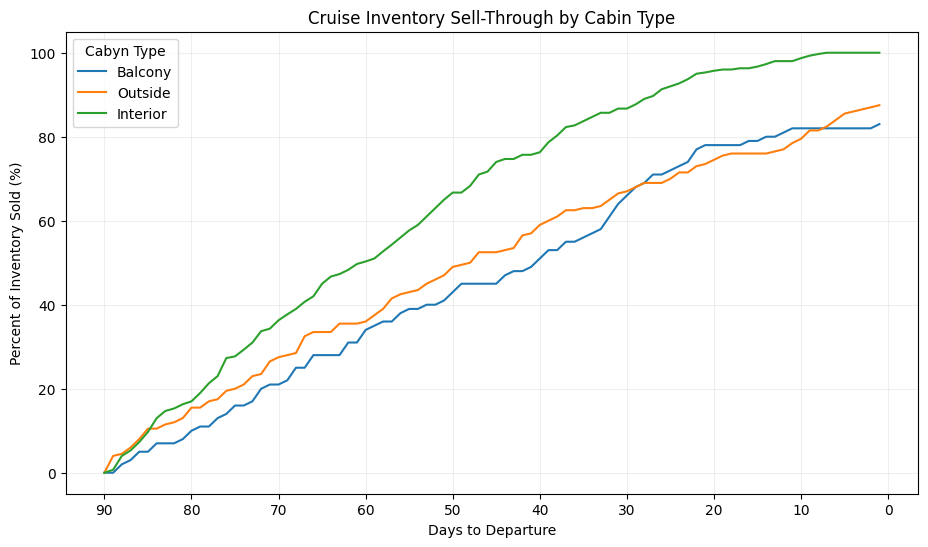

In [259]:
plt.figure(figsize=(11, 6))

for cabin in df["cabin_type"].unique():
    subset = df[df["cabin_type"] == cabin]
    plt.plot(
        subset["days_to_departure"],
        subset["pct_sold"],
        label=cabin
    )

# x-axis formatting
ticks = list(range(
    df["days_to_departure"].max(),
    -1,
    -10
))

plt.xticks(ticks)
plt.gca().invert_xaxis()
plt.xlabel("Days to Departure")
plt.ylabel("Percent of Inventory Sold (%)")
plt.title("Cruise Inventory Sell-Through by Cabin Type")
plt.legend(title="Cabyn Type")
plt.grid(alpha=0.2)
plt.savefig(
    "../figures/02_Cruise_Inventory_by_Cabin_Type.png",
    dpi=300,
    bbox_inches="tight")
plt.show()

In [260]:
analysis_df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
).copy()

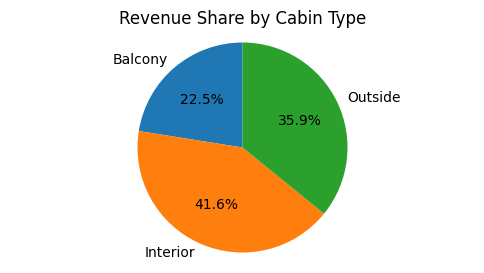

In [261]:
revenue_by_cabin = (
    df.groupby("cabin_type")["daily_revenue"]
      .sum()
      .reset_index()
)

plt.figure(figsize=(6, 3))

plt.pie(
    revenue_by_cabin["daily_revenue"],
    labels=revenue_by_cabin["cabin_type"],
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Revenue Share by Cabin Type")
plt.axis("equal")  # keeps pie circular
plt.savefig(
    "../figures/02_revenue_share_by_cabin_type.png",
    dpi=300,
    bbox_inches="tight")
plt.show()

In [262]:
column_order = [
    # Time & product
    "date",
    "days_to_departure",
    "cabin_type",

    # Inventory state
    "total_inventory",
    "remaining_inventory",

    # Pricing setup
    "base_price",
    "price_floor",
    "price_cap",

    # Demand & pricing drivers (environment)
    "demand_index",
    "elasticity",
    "daily_shock",
    "inventory_pressure",

    # Price outcome (decision)
    "price",

    # Booking realization (simulation outcome)
    "demand_shock",
    "bookings",

    # Revenue & sell-through
    "daily_revenue",
    "cumulative_revenue",
    "pct_sold"
]
df = df[column_order]

In [263]:
df.head(10)

,date,days_to_departure,cabin_type,total_inventory,remaining_inventory,base_price,price_floor,price_cap,demand_index,elasticity,daily_shock,inventory_pressure,price,demand_shock,bookings,daily_revenue,cumulative_revenue,pct_sold
0,2025-10-21,90,Balcony,100,100,500,450,1000,0.051196,0.9,0.056335,0.0,525.0,2.004445,0,0.0,0.0,0.0
1,2025-10-21,90,Outside,200,200,350,320,750,0.054753,1.2,-0.053060,0.0,351.0,1.918507,8,2808.0,2808.0,0.0
2,2025-10-21,90,Interior,300,300,250,250,600,0.044382,1.4,-0.048535,0.0,263.0,1.055716,2,526.0,526.0,0.0
3,2025-10-22,89,Interior,300,298,250,250,600,0.043721,1.4,-0.024348,0.0,265.0,1.111212,10,2650.0,3176.0,0.7
4,2025-10-22,89,Outside,200,192,350,320,750,0.048496,1.2,-0.052824,0.0,351.0,0.925795,1,351.0,3159.0,4.0
5,2025-10-22,89,Balcony,100,100,500,450,1000,0.059975,0.9,-0.026785,0.0,507.0,0.949090,2,1014.0,1014.0,0.0
6,2025-10-23,88,Outside,200,191,350,320,750,0.050937,1.2,-0.056809,0.0,356.0,0.835283,3,1068.0,4227.0,4.5
7,2025-10-23,88,Balcony,100,98,500,450,1000,0.059957,0.9,-0.034660,0.0,509.0,0.795302,1,509.0,1523.0,2.0
8,2025-10-23,88,Interior,300,288,250,250,600,0.040305,1.4,0.050585,0.0,264.0,0.804180,4,1056.0,4232.0,4.0
9,2025-10-24,87,Outside,200,188,350,320,750,0.051288,1.2,-0.050048,0.0,358.0,1.189239,4,1432.0,5659.0,6.0


In [264]:
# ===============================
# 17. Save final dataset
# ===============================
df.to_csv("../data/processed/cruise_pricing_with_bookings.csv", index=False)